In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy import optimize
import pandas as pd
import nlopt

In [2]:
# Functions for sampling and finding kin
import sampling_and_kin_functions as skf

In [3]:
# True values of parameters for SLiM simulation
max_a = 37
max_t = 60
R0 = 10
eta1_tilde = np.exp(-2.904)
eta2_tilde = 1 + np.exp(0.586)
eta3_tilde = np.exp(-2.579)
c = 1.111
nu11_tilde = 1.264
nu12_tilde = 5.424
nu21_tilde = 1.868
nu22_tilde = 6.5
true_params = [R0, eta1_tilde, eta2_tilde, eta3_tilde, nu11_tilde, nu12_tilde, nu21_tilde, nu22_tilde]

In [4]:
%%bash
slim -s 120 -d R0=10 -d 'OUTPUT="bearded_seal_parents.csv"' -d 'POPSIZE_FILE="bearded_seal_popsize.csv"' bearded_seals.slim

// Initial random seed:
120

// RunInitializeCallbacks():
initializeSLiMModelType(modelType = 'nonWF');
initializeSLiMOptions(keepPedigrees = T, dimensionality = 'xy');
initializeSex("A");
22026
initializeInteractionType(1, "xy", reciprocal=T, maxDistance=0.56419, sexSegregation="FM");
initializeMutationType(1, 0.5, "f", 0);
initializeGenomicElementType(1, m1, 1);
initializeGenomicElement(g1, 0, 99999);
initializeMutationRate(0);
initializeRecombinationRate(1e-08);

// Starting run at tick <start>:
1 



"Late pop size"
17574
"Late pop size"
17554
"Late pop size"
17580
"Late pop size"
17425
"Late pop size"
17378
"Late pop size"
17305
"Late pop size"
17183
"Late pop size"
17069
"Late pop size"
17100
"Late pop size"
17009
"Late pop size"
16930
"Late pop size"
17021
"Late pop size"
17071
"Late pop size"
17094
"Late pop size"
17180
"Late pop size"
17161
"Late pop size"
16981
"Late pop size"
16903
"Late pop size"
16908
"Late pop size"
16837
"Late pop size"
16884
"Late pop size"
17011
"Late pop size"
17063
"Late pop size"
17144
"Late pop size"
17173
"Late pop size"
17195
"Late pop size"
17185
"Late pop size"
17305
"Late pop size"
17228
"Late pop size"
17169
"Late pop size"
17011
"Late pop size"
17011
"Late pop size"
17000
"Late pop size"
17030
"Late pop size"
17091
"Late pop size"
17108
"Late pop size"
17050
"Late pop size"
17100
"Late pop size"
17017
"Late pop size"
17126
"Late pop size"
17199
"Late pop size"
17167
"Late pop size"
17206
"Late pop size"
17088
"Late pop size"
17100
"Late pop 

In [5]:
# Example data
parents = pd.read_csv("bearded_seal_parents.csv")

In [7]:
# Add birth year to the data frame
# Because individuals are 1 in the year they are born, add 1
parents["birth_year"] = parents["sampling_time"] - parents["age"] + 1

In [8]:
# Define sampling intensity grid with one side [bias] times as likely to be sampled as the other
sampling_intensity =  np.repeat([np.linspace(1, 10, 10)], 10, axis = 0)

# Sample according to the grid and return realized sampling size and sampled individuals
ss, sample_rows = skf.sample_grid(parents, sampling_intensity, 2000, 10, 10)
sample_parents = parents.iloc[sample_rows]

# Find individuals in the sample that have a child in the sample
ind_in_p1 = np.isin(sample_parents.loc[:,'individual'].values, sample_parents.loc[:,'parent1'])
ind_in_p2 = np.isin(sample_parents.loc[:,'individual'].values, sample_parents.loc[:,'parent2'])

# Mothers and Fathers
mothers = sample_parents[ind_in_p1]
fathers = sample_parents[ind_in_p2]
mother_list = mothers.loc[:,'individual'].values
father_list = fathers.loc[:,'individual'].values

# Find the parents of children in the sample and how many children in the sample they have (the parents don't need to be in the sample)
# Mothers are parent1 and fathers are parent2
all_mothers, all_mother_counts = np.unique(sample_parents.loc[:,'parent1'].values, return_counts = True)
all_fathers, all_father_counts = np.unique(sample_parents.loc[:,'parent2'].values, return_counts = True)

# Find parents with multiple children in the sample (parents of siblings)
maternal_sib_parents = all_mothers[all_mother_counts > 1]
paternal_sib_parents = all_fathers[all_father_counts > 1]

# Record POPs and half-sibling pairs
# POPs are [parent, offspring], sibs are [sib1, sib2] where sib1 is the sibling with a lower id number (which might mean younger but I'd need to check)
maternal_pops = skf.find_POPs_or_sibs(mother_list, sample_parents, "PO")
paternal_pops = skf.find_POPs_or_sibs(father_list, sample_parents, "PO")
maternal_sibs = skf.find_POPs_or_sibs(maternal_sib_parents, sample_parents, "HS")
paternal_sibs = skf.find_POPs_or_sibs(paternal_sib_parents, sample_parents, "HS")

# Full sibling pairs appear in both maternal and paternal arrays
if np.any([x in paternal_sibs for x in maternal_sibs]):
    full_sibs = maternal_sibs[np.where([x in paternal_sibs for x in maternal_sibs])[0][0]]
else:
    full_sibs = []

In [9]:
# Initialize empty dictionaries to keep track of counts
parent_counts = {}
sibling_counts = {}

# For each parent birth year b1, parent capture year y1, offspring birth year b2, and parent sex g
# Count the number of parent offspring pairs
pairs = np.concatenate([maternal_pops, paternal_pops])
sample_array = sample_parents
# pairs: An array of tuples of individual ids
# sample_array: Array containing information about each individual
for pair in pairs:
    index1 = np.where(sample_array.loc[:,'individual'] == pair[0])
    index2 = np.where(sample_array.loc[:,'individual'] == pair[1])
    row1 = sample_array.iloc[index1]
    row2 = sample_array.iloc[index2]
    b1 = row1['birth_year'].values[0]
    b2 = row2['birth_year'].values[0]
    y1 = row1['sampling_time'].values[0]
    g =  row1['sex'].values[0]
    parent_counts[(b1, y1, b2, g)] = parent_counts.get((b1, y1, b2, g), 0) + 1

# For each older sibling birth year b1, younger sibling birth year b2, and parent sex g,
# count the number of sibling pairs
pairs = maternal_sibs
# pairs: An array of tuples of individual ids
for pair in pairs:
    index1 = np.where(sample_array.loc[:,'individual'] == pair[0])
    index2 = np.where(sample_array.loc[:,'individual'] == pair[1])
    row1 = sample_array.iloc[index1]
    row2 = sample_array.iloc[index2]
    sib1_b = row1['birth_year'].values[0]
    sib2_b = row2['birth_year'].values[0]
    b1, b2 = sorted([sib1_b, sib2_b])
    g = 'F'
    sibling_counts[(b1, b2, g)] = sibling_counts.get((b1, b2, g), 0) + 1
pairs = paternal_sibs
# pairs: An array of tuples of individual ids
for pair in pairs:
    index1 = np.where(sample_array.loc[:,'individual'] == pair[0])
    index2 = np.where(sample_array.loc[:,'individual'] == pair[1])
    row1 = sample_array.iloc[index1]
    row2 = sample_array.iloc[index2]
    sib1_b = row1['birth_year'].values[0]
    sib2_b = row2['birth_year'].values[0]
    b1, b2 = sorted([sib1_b, sib2_b])
    g = 'M'
    sibling_counts[(b1, b2, g)] = sibling_counts.get((b1, b2, g), 0) + 1

print(parent_counts)
print(sibling_counts)


{(np.int64(48), np.int64(55), np.int64(55), 'F'): 1, (np.int64(34), np.int64(47), np.int64(44), 'F'): 1, (np.int64(55), np.int64(59), np.int64(59), 'F'): 1, (np.int64(46), np.int64(50), np.int64(50), 'F'): 1, (np.int64(37), np.int64(54), np.int64(50), 'F'): 1, (np.int64(37), np.int64(41), np.int64(41), 'F'): 1, (np.int64(23), np.int64(45), np.int64(42), 'F'): 1, (np.int64(39), np.int64(45), np.int64(44), 'F'): 1, (np.int64(45), np.int64(54), np.int64(48), 'F'): 1, (np.int64(28), np.int64(57), np.int64(55), 'F'): 1, (np.int64(28), np.int64(57), np.int64(47), 'F'): 1, (np.int64(35), np.int64(45), np.int64(40), 'F'): 1, (np.int64(35), np.int64(45), np.int64(43), 'F'): 1, (np.int64(43), np.int64(49), np.int64(47), 'F'): 1, (np.int64(24), np.int64(44), np.int64(38), 'F'): 1, (np.int64(36), np.int64(51), np.int64(41), 'F'): 1, (np.int64(45), np.int64(53), np.int64(52), 'F'): 1, (np.int64(31), np.int64(42), np.int64(42), 'F'): 1, (np.int64(41), np.int64(52), np.int64(51), 'F'): 1, (np.int64(4

### Counting the number of comparisons for each combination of birth and sampling years

The number of parent comparisons is $n_{b_1, y_1, b_2, g} = N_{b_1, y_1, g} \times \sum_{y, g} N_{b_2, y, g}$

$$
b_1 \in \{y_1 - 37, \dots, y_1 - 1\}\\ y_1 \in \{40, \dots, 60\}\\ b_2 \in \{b_1 + 1, \dots, y_1\} \\ g \in \{1, 2\}
$$

The number of sibling comparisons is $n_{b_1, b_2, g}' = \sum_{y, g} N_{b_1, y, g} \times \sum_{y, g} N_{b_2, y, g}$

$$
b_1 \in \{1, 2, \dots, 60\} \\ b_2 \in \{b_1, \dots, 60 \} \\ g \in \{1, 2\}
$$

In [10]:
# Number of individuals born in each year
b_grouped = sample_parents.groupby(['birth_year'])
b_counts = {key: len(value) for key, value in b_grouped.groups.items()}
print(b_counts)
# Number of individuals of each birth year, capture year, and sex
byg_grouped = sample_parents.groupby(['birth_year', 'sampling_time', 'sex'])
byg_counts = {key: len(value) for key, value in byg_grouped.groups.items()}
print(byg_counts)

{20: 1, 21: 2, 22: 4, 23: 3, 24: 6, 25: 6, 26: 5, 27: 8, 28: 12, 29: 13, 30: 8, 31: 15, 32: 17, 33: 31, 34: 24, 35: 32, 36: 34, 37: 45, 38: 48, 39: 59, 40: 92, 41: 96, 42: 94, 43: 101, 44: 108, 45: 91, 46: 97, 47: 109, 48: 91, 49: 83, 50: 81, 51: 93, 52: 92, 53: 62, 54: 66, 55: 73, 56: 64, 57: 60, 58: 49, 59: 42, 60: 33}
{(20, 40, 'M'): 1, (21, 42, 'F'): 1, (21, 44, 'M'): 1, (22, 43, 'F'): 1, (22, 44, 'M'): 1, (22, 45, 'F'): 2, (23, 41, 'F'): 1, (23, 44, 'F'): 1, (23, 45, 'F'): 1, (24, 41, 'F'): 2, (24, 41, 'M'): 2, (24, 44, 'F'): 1, (24, 44, 'M'): 1, (25, 40, 'F'): 1, (25, 40, 'M'): 1, (25, 41, 'M'): 1, (25, 43, 'F'): 2, (25, 48, 'F'): 1, (26, 40, 'M'): 2, (26, 41, 'F'): 2, (26, 42, 'F'): 1, (27, 40, 'M'): 1, (27, 41, 'F'): 1, (27, 42, 'F'): 2, (27, 42, 'M'): 1, (27, 43, 'M'): 1, (27, 47, 'F'): 1, (27, 49, 'F'): 1, (28, 41, 'M'): 1, (28, 43, 'F'): 1, (28, 43, 'M'): 3, (28, 44, 'M'): 1, (28, 45, 'M'): 3, (28, 46, 'M'): 1, (28, 50, 'F'): 1, (28, 57, 'F'): 1, (29, 40, 'F'): 2, (29, 40, '

In [11]:
# Number of parent offspring pair comparisons
# Initialize dictionary
parent_comparisons = {}
max_a = 37
# Loop through all parents
for b1, y1, g in byg_counts.keys():
    # Loop through all offpsring
    for b2 in b_counts.keys():
        if (y1 >= b2 and b1 < y1 <= b1 + max_a and b1 <= b2 <= b1 + max_a):
            parent_comparisons[(b1, y1, b2, g)] = byg_counts[(b1, y1, g)] * b_counts[b2]                   
print(parent_comparisons)
for b1, y1, b2, g in parent_counts.keys():
    if(parent_comparisons[(b1, y1, b2, g)] < parent_counts[(b1, y1, b2, g)]):
        print("Error, more PO pairs than possible")
        break

# Number of half-sibling pair comparisons
# Initialize dictionary
sibling_comparisons = {}
# Loop through all older siblings
for b1 in b_counts.keys():
    # Loop through all younger siblings
    for b2 in b_counts.keys():
        if b2 >= b1:
            sibling_comparisons[(b1, b2, 'F')] = b_counts[b1] * b_counts[b2] 
            sibling_comparisons[(b1, b2, 'M')] = b_counts[b1] * b_counts[b2]                  
print(sibling_comparisons)
for b1, b2, g in sibling_counts.keys():
    if(sibling_comparisons[(b1, b2, g)] < sibling_counts[(b1, b2, g)]):
        print("Error, more sibling pairs than possible")
        break

{(20, 40, 20, 'M'): 1, (20, 40, 21, 'M'): 2, (20, 40, 22, 'M'): 4, (20, 40, 23, 'M'): 3, (20, 40, 24, 'M'): 6, (20, 40, 25, 'M'): 6, (20, 40, 26, 'M'): 5, (20, 40, 27, 'M'): 8, (20, 40, 28, 'M'): 12, (20, 40, 29, 'M'): 13, (20, 40, 30, 'M'): 8, (20, 40, 31, 'M'): 15, (20, 40, 32, 'M'): 17, (20, 40, 33, 'M'): 31, (20, 40, 34, 'M'): 24, (20, 40, 35, 'M'): 32, (20, 40, 36, 'M'): 34, (20, 40, 37, 'M'): 45, (20, 40, 38, 'M'): 48, (20, 40, 39, 'M'): 59, (20, 40, 40, 'M'): 92, (21, 42, 21, 'F'): 2, (21, 42, 22, 'F'): 4, (21, 42, 23, 'F'): 3, (21, 42, 24, 'F'): 6, (21, 42, 25, 'F'): 6, (21, 42, 26, 'F'): 5, (21, 42, 27, 'F'): 8, (21, 42, 28, 'F'): 12, (21, 42, 29, 'F'): 13, (21, 42, 30, 'F'): 8, (21, 42, 31, 'F'): 15, (21, 42, 32, 'F'): 17, (21, 42, 33, 'F'): 31, (21, 42, 34, 'F'): 24, (21, 42, 35, 'F'): 32, (21, 42, 36, 'F'): 34, (21, 42, 37, 'F'): 45, (21, 42, 38, 'F'): 48, (21, 42, 39, 'F'): 59, (21, 42, 40, 'F'): 92, (21, 42, 41, 'F'): 96, (21, 42, 42, 'F'): 94, (21, 44, 21, 'M'): 2, (21, 

In [12]:
# Survival, fecundity, and population size

def S(a, eta1_tilde, eta2_tilde, eta3_tilde, c):
    """
    Survival function
    """
    S = np.exp(-c*((eta1_tilde*a)**eta2_tilde + (eta1_tilde*a)**(1/eta2_tilde) + eta3_tilde - (eta1_tilde*(a-1))**eta2_tilde - (eta1_tilde*(a-1))**(1/eta2_tilde)))
    #S = np.exp(-c*((eta1_tilde*a)**eta2_tilde + (eta1_tilde*a)**(1/eta2_tilde) + eta3_tilde*a))
    return(S)
def f(a, nug1_tilde, nug2_tilde):
    """
    Fecundity function
    """
    return((1 + np.exp(-nug1_tilde*(a - nug2_tilde)))**(-1))
def N(params, max_a, max_t, c):
    """
    Number of males and females of ages 1, ..., max_a at years 1, ..., max_t
    """
    R0, eta1_tilde, eta2_tilde, eta3_tilde, nu11_tilde, nu12_tilde, nu21_tilde, nu22_tilde = params
    N_males = np.zeros((max_a + 1, max_t + 1))
    N_females = np.zeros((max_a + 1, max_t + 1))
    ages = np.arange(max_a + 1)
    years = np.arange(max_t + 1)
    # Set all time 0 population sizes to NA because time starts at 1
    N_males[:, 0] = None
    N_females[:, 0] = None
    # Set all age 0 population sizes to NA because age starts at 1
    N_males[0,:] = None
    N_females[0,:] = None
    # Initialize the population at time 1
    N_males[1, 1] = np.exp(R0)
    N_females[1, 1] = np.exp(R0)
    # For ages 2 to max_a, initialize as a stable age distribution
    for a in ages[2:]:
        S_amin1 = S(a - 1, eta1_tilde, eta2_tilde, eta3_tilde, c)
        N_males[a, 1] = N_males[a - 1, 1] * S_amin1
        N_females[a, 1] = N_females[a - 1, 1] * S_amin1
        #print("age: ", a, "time: 1", "Ns: ", N_males[a, 1], "   ", N_females[a, 1])
    for t in years[2:]:
        # Survival model
        for a in ages[2:]:
            S_amin1 = S(a - 1, eta1_tilde, eta2_tilde, eta3_tilde, c)
            N_males[a, t] = N_males[a - 1, t - 1] * S_amin1
            N_females[a, t] = N_females[a - 1, t - 1] * S_amin1
            #print("age: ", a, "time: ", t, "Ns: ", N_males[a, 1], "   ", N_females[a, 1])
        #print("age: ", 1, "time: ", t, "Ns: ", N_males[a, 1], "   ", N_females[a, 1])
        # Fecundity model
        n_new_offspring = np.sum([f(a, nu11_tilde, nu12_tilde) * N_females[a, t] for a in ages[2:,]])
        #print(n_new_offspring)
        N_males[1, t] = 0.5 * n_new_offspring
        N_females[1, t] = 0.5 * n_new_offspring
    return N_females, N_males

In [13]:
N_females, N_males = N(true_params, max_a, max_t, c)


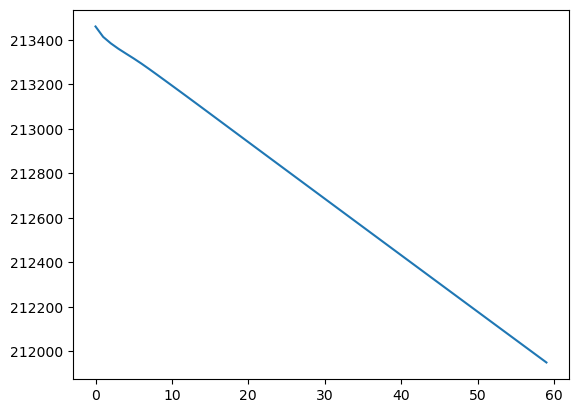

In [14]:
N_total = np.sum(N_females[1:,1:], 0) + np.sum(N_males[1:,1:], 0)
plt.plot(N_total)

### Parent-offspring probabilities

The number of offspring born to parents of sex g in year $b_2$ is:

$$
\sum_{a=2}^{37} N_{a, b_2, g}f(a,g)
$$

An individual that was born in year $b_1 < b_2$ was $b_2 - b1 + 1$ years old in year $b_2$ and on average had $f(b_2 - b_1 + 1,g)$ offspring in year $b_2$.

An individual born in year $b_1$ and sampled in year $y_1$ can be the parent of an individual born in year  $b_2$ if:

- Parent was sampled in the year of the offspring’s birth or after: $y_1 \geq b2$
- Parent was sampled within its lifetime: $b_1 < y_1 \leq b_1 + 37$
- Offspring was born before the parent died: $b_2 \leq b_1 + 37$

So, the parent-offspring pair probability for parent birth year, parent capture year, offspring birth year, and parent sex $b_1, y_1, b_2, g$ is:

$$
\frac{f(b_2 - b_1 + 1, g)}{\sum_{a=2}^{37} N_{a, b_2, g}f(a,g)}, y_1 \geq b_2, b_1 < y_1 \leq b_1 + 37, b_2 \leq b_1 + 37
$$

In [16]:
# Calculating probability of parent-offspring pair
b1 = 20 # Parent birth year
y1 = 50 # Parent capture year
b2 = 40 # Offspring birth year
g = 'F' # Parent sex
def POP_probability(b1, y1, b2, g, N_females, N_males, max_a = 37):
    ages = np.arange(1,max_a + 1)
    if y1 >= b2 and b1 < y1 <= b1 + max_a and b1 <= b2 <= b1 + max_a:
        if g == 'F':
            nug1_tilde = nu11_tilde
            nug2_tilde = nu12_tilde
            N_g = N_females
        if g =='M':
            nug1_tilde = nu21_tilde
            nug2_tilde = nu22_tilde
            N_g = N_males
        # Total reproductive output in the offpsring birth year of all individuals of gender g alive at that time
        erro = np.sum([f(a, nug1_tilde, nug2_tilde) * N_g[a, b2] for a in ages[2:]])
        # Fecundity of parent in offspring birth year
        f_parent = f(b2 - b1 + 1, nug1_tilde, nug2_tilde)
        p_pop = f_parent/erro
    else:
        p_pop = 0
    return(p_pop)
print(POP_probability(b1, y1, b2, g, N_females, N_males))

2.2912075574474796e-05


In [17]:
# Check that the expected number of parent-offspring pairs for each comparison category is close to observed
expected_parent_counts = []
observed_parent_counts = []
for b1, y1, b2, g in parent_comparisons.keys():
    expected_count = POP_probability(b1, y1, b2, g, N_females, N_males)*parent_comparisons[(b1, y1, b2, g)]
    observed_count = parent_counts.get((b1, y1, b2, g), 0)
    expected_parent_counts.append(expected_count)
    observed_parent_counts.append(observed_count)
print(sum(observed_parent_counts))
print(sum(expected_parent_counts))

101
7.204387346318324


### Half sibling probabilities

Older sibling birth year $b_1$, younger sibling birth year $b_2$, parent sex $g$

In year $b_1$, there are $N_a, b_1, g$ potential parents of age $a$ and sex $g$.

The probability that one of these potential parents is the parent of the older sibling is:

$$
\frac{f(a, g)}{\sum_{a'=2}^{37} N_{a', b_1, g}f(a',g)}
$$

Between the reproduction step of year $b_1$ and the reproduction step of year $b_2$, an individual goes through the survival step in years $y\in [b_1, ..., b_2 - 1]$. If the individual is of age $a$ in year $b_1$, then it is age $a^* = a + y - b_1 \in [a,...,a + b_2 - 1 - b_1]$. So the probability that the potential parent survives until the reproduction step of the year the younger sibling is born is:

$$
\prod_{y = b_1}^{b_2-1}S_{a + y - b_1}
$$

In the year of the younger siblings birth, the potential parent is age $a + b_2 - b_1$.

The probability the potential parent is the sibling of the younger sibling is:

$$
\frac{f(a + b_2 - b_1, g)}{\sum_{a'=2}^{37} N_{a', b_2, g}f(a',g)}
$$

So the half-sibling probability is:

$$
\sum_{a = 1}^{37} \frac{f(a, g)}{\sum_{a'=2}^{37} N_{a', b_1, g}f(a',g)}\prod_{y = b_1}^{b_2-1}S_{a + y - b_1}\frac{f(a + b_2 - b_1, g)}{\sum_{a'=2}^{37} N_{a', b_2, g}f(a',g)}
$$

In [18]:
# Calculating probability of half-sibling pair
b1 = 10 # Older sibling birth year
b2 = 40 # Younger sibling birth year
g = 'F' # Parent sex
max_a = 37
def HS_probability(b1, b2, g, N_females, N_males, max_a = 37):
    if b2 < b1:
        return(0)
    ages = np.arange(1,max_a + 1)
    if g == 'F':
        nug1_tilde = nu11_tilde
        nug2_tilde = nu12_tilde
        N_g = N_females
    if g =='M':
        nug1_tilde = nu21_tilde
        nug2_tilde = nu22_tilde
        N_g = N_males
    p_hs = 0
    # Sum over all possible ages
    for a in ages:
        # Total number of individuals of sex g and age a in the older sibling birth year
        N_ab1g = N_g[a, b1]
        # Total expected reproductive output of all individuals of sex g in the older sibling birth year
        erro_b1 = np.sum([f(a_prime, nug1_tilde, nug2_tilde) * N_g[a_prime, b1] for a_prime in ages[2:]])
        # Probability that an individual of age a in the older sibling birth year is the parent of the older sibling
        p_parent_older_sib = f(a, nug1_tilde, nug2_tilde)/erro_b1
        # Probability that an individual of age a in the older sibling birth year survived until the younger sibling birth year
        p_survived = np.prod([S(a + y - b1, eta1_tilde, eta2_tilde, eta3_tilde, c) for y in np.arange(b1, b2)])
        # Total expected reproductive output of all individuals of sex g in the younger sibling birth year
        erro_b2 = np.sum([f(a_prime, nug1_tilde, nug2_tilde) * N_g[a_prime, b2] for a_prime in ages[2:]])
        # Probability that an individual of age a in the older sibling birth year is the parent of the younber sibling
        p_parent_younger_sib = f(a + b2 - b1, nug1_tilde, nug2_tilde)/erro_b2
        p_hs += N_ab1g * p_parent_older_sib * p_survived * p_parent_younger_sib
    return(p_hs)
print(HS_probability(b1, b2, g, N_females, N_males, max_a))


5.056123527246669e-10


### Likelihood

Parameters to estimate: $R_0, \tilde{\eta}_1, \tilde{\eta}_2, \tilde{\eta}_3, \tilde{\nu}_{11}, \tilde{\nu}_{12}, \tilde{\nu}_{21}, \tilde{\nu}_{22}$

Observations: $m_{b_1, y_1, b_2, g}, n_{b_1, y_1, b_2, g}, m' _{b_1, b_2, g}, n' _{b_1, b_2, g}$, where $m$ is the number of parent-offspring pairs, $n$ is the number of comparisons for parent-offspring pairs, and $m^\prime$ and $n^\prime$ are the same but for sibling pairs.

Using the poisson approximation to the binomial distribution, the log-likelihood for parent-offspring pairs is then:

The negative log-likelihood for parent-offspring pairs is:

$$
\sum_{b_1}\sum_{y_1}\sum_{b_2}\sum_{g} \left(- m_{b_1, y_1, b_2, g} \log (n_{b_1, y_1, b_2, b} P_{b_1, y_1, b_2, g}) + n_{b_1, y_1, b_2, g} P_{b_1, y_1, b_2, g} \right)
$$

and the negative log-likelihood for half-sibling pairs is:

$$
\sum_{b_1}\sum_{b_2}\sum_{g} \left( - m_{b_1, b_2, g}' \log (n_{b_1, b_2, g}' P_{b_1, b_2, g}' )+ n_{b_1, b_2, g}' P_{b_1, b_2, g}'\right)
$$

The negative log likelihood for the priors on the survival parameters is:

$$
-\sum_{i=1}^3 \log\left( \mathcal{N}(\tilde{\eta}_i|\eta_i, \sigma^2_i)\right)
$$

And the negative log likelihood for the priors on the fecundity parameters is:

$$
-\sum_{i=1}^2 \sum_{g=1}^2 \log\left( \mathcal{N}(\tilde{\nu}_{g,i}|\nu_{g,i}, \tau^2_{g,i})\right)
$$

where $\mathcal{N}$ is a normal pdf.

The negative log-likelihood is then:

$$
\Lambda(R_0, \tilde{\eta}_1, \tilde{\eta}_2, \tilde{\eta}_3, \tilde{\nu}_{11}, \tilde{\nu}_{12}, \tilde{\nu}_{21}, \tilde{\nu}_{22} |\mathbf{m}, \mathbf{n}, \mathbf{m}' , \mathbf{n}' ) = \\\sum_{b_1}\sum_{y_1}\sum_{b_2}\sum_{g} \left( -m_{b_1, y_1, b_2, g} \log (n_{b_1, y_1, b_2, b} P_{b_1, y_1, b_2, g}) + n_{b_1, y_1, b_2, g} P_{b_1, y_1, b_2, g}\right) + \sum_{b_1}\sum_{b_2}\sum_{g} \left( -m_{b_1, b_2, g}' \log (n_{b_1, b_2, g}' P_{b_1, b_2, g}' )+ n_{b_1, b_2, g}' P_{b_1, b_2, g}'\right)-\\\sum_{i=1}^3 \log\left( \mathcal{N}(\tilde{\eta}_i|\eta_i, \sigma^2_i)\right)-\sum_{i=1}^2 \sum_{g=1}^2 \log\left( \mathcal{N}(\tilde{\nu}_{g,i}|\nu_{g,i}, \tau^2_{g,i})\right)
$$

In [19]:
def nll(params, survival_prior_params, fecundity_prior_params, parent_counts, sibling_counts, parent_comparisons, sibling_comparisons, c = 1.111, max_a = 37, max_t = 60):
    """
    Log likelihood function of params given parent and sibling pair counts
    Parameters to estimate: R0, eta1_tilde, eta2_tilde, eta3_tilde, nu11_tilde, nu12_tilde, nu21_tilde, nu22_tilde
    Observations: parent_counts, sibling_counts, parent_comparisons, sibling_comparisons
    """
    # Unpack the parameters
    R0, eta1_tilde, eta2_tilde, eta3_tilde, nu11_tilde, nu12_tilde, nu21_tilde, nu22_tilde = params
    eta1, eta2, eta3, sigma1, sigma2, sigma3 = survival_prior_params
    nu11, nu12, nu21, nu22, tau11, tau12, tau21, tau22 = fecundity_prior_params
    # Population size model
    N_females, N_males = N(params, max_a, max_t, c)
    # Parent section of the negative log likelihood
    PO_nll = 0
    for b1, y1, b2, g in parent_comparisons.keys():
        p_pop = POP_probability(b1, y1, b2, g, N_females = N_females, N_males = N_males, max_a = max_a)
        n = parent_comparisons[(b1, y1, b2, g)]
        m = parent_counts.get((b1, y1, b2, g), 0)
        if p_pop != 0:
            PO_nll += -m*np.log(n*p_pop) + n*p_pop
    #print(PO_nll)
    # Sibling section of the negative log likelihood
    HS_nll = 0
    for b1, b2, g in sibling_comparisons.keys():
        p_hs = HS_probability(b1, b2, g, N_females = N_females, N_males = N_males, max_a = max_a)
        n_prime = sibling_comparisons[(b1, b2, g)]
        m_prime = sibling_counts.get((b1, b2, g), 0)
        if p_hs != 0:
            HS_nll += -m_prime*np.log(n_prime*p_hs) + n_prime*p_hs
    #print(HS_nll)
    # Negative log likelihood for priors on the survival parameters
    survival_nll = -(stats.norm.logpdf(eta1_tilde, eta1, sigma1) + stats.norm.logpdf(eta2_tilde, eta2, sigma2) + stats.norm.logpdf(eta3_tilde, eta3, sigma3))
    # Negative log likelihood for priors on the fecundity parameters
    fecundity_nll = -(stats.norm.logpdf(nu11_tilde, nu11, tau11) + stats.norm.logpdf(nu12_tilde, nu12, tau12) +
                    stats.norm.logpdf(nu21_tilde, nu21, tau21) + stats.norm.logpdf(nu22_tilde, nu22, tau22))
    nll = PO_nll + HS_nll + survival_nll + fecundity_nll
    return(nll)
    

In [20]:
# Prior parameters
# Means and SDs for normal priors on survival parameters
survival_priors = 0.055, 2.8, 0.076, np.exp(0.15), np.exp(0.25), np.exp(0.5)
# Means and SDs for normal priors on fecundity parameters
fecundity_priors = 1.264, 5.424, 1.868, 6.5, 0.4*1.264, 0.4*5.424, 0.4*1.868, 0.4*6.5
print(nll(true_params, survival_priors, fecundity_priors, parent_counts, sibling_counts, parent_comparisons, sibling_comparisons))

1406.7839212357474


In [21]:
# Plot the negative log likelihood as a function of R0
# for eta1_tilde, eta2_tilde, eta3_tilde, nu11_tilde, nu12_tilde, nu21_tilde, nu22_tilde
# fixed to be the mean of their priors
eta1, eta2, eta3, sigma1, sigma2, sigma3 = survival_priors
nu11, nu12, nu21, nu22, tau11, tau12, tau21, tau22 = fecundity_priors
eta1_tilde, eta2_tilde, eta3_tilde, nu11_tilde, nu12_tilde, nu21_tilde, nu22_tilde = eta1, eta2, eta3, nu11, nu12, nu21, nu22
R0s = np.linspace(7, 12, 21)
nlls = np.empty(len(R0s))
for i in range(len(R0s)):
    params = [R0s[i], eta1_tilde, eta2_tilde, eta3_tilde, nu11_tilde, nu12_tilde, nu21_tilde, nu22_tilde]
    nlls[i] = nll(params, survival_priors, fecundity_priors, parent_counts, sibling_counts, parent_comparisons, sibling_comparisons)

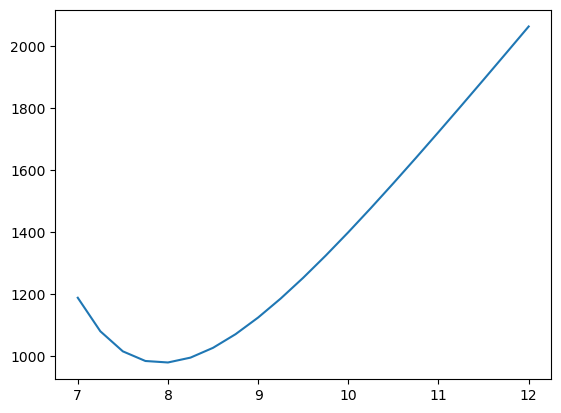

In [22]:
plt.plot(R0s, nlls)

In [27]:
# Plot the negative log likelihood as a function of eta1_tilde
# for eta1_tilde, eta2_tilde, eta3_tilde, nu11_tilde, nu12_tilde, nu21_tilde, nu22_tilde
# fixed to be the mean of their priors
eta1, eta2, eta3, sigma1, sigma2, sigma3 = survival_priors
nu11, nu12, nu21, nu22, tau11, tau12, tau21, tau22 = fecundity_priors
eta1_tilde, eta2_tilde, eta3_tilde, nu11_tilde, nu12_tilde, nu21_tilde, nu22_tilde = eta1, eta2, eta3, nu11, nu12, nu21, nu22
R0 = 10
eta1_tildes = np.linspace(0.05, 0.1, 10)
nlls = np.empty(len(eta1_tildes))
for i in range(len(eta1_tildes)):
    params = [R0, eta1_tildes[i], eta2_tilde, eta3_tilde, nu11_tilde, nu12_tilde, nu21_tilde, nu22_tilde]
    nlls[i] = nll(params, survival_priors, fecundity_priors, parent_counts, sibling_counts, parent_comparisons, sibling_comparisons)

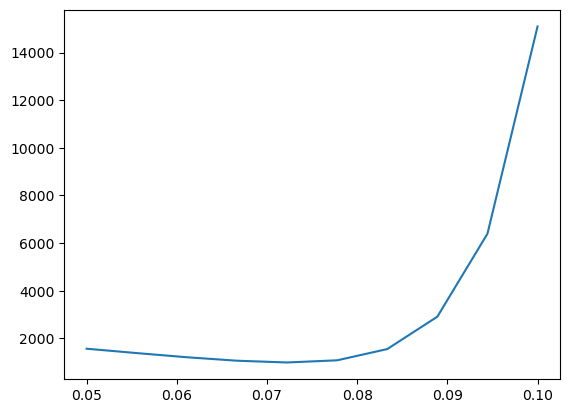

In [28]:
plt.plot(eta1_tildes, nlls)

### Estimate R0 with NLOpt

In [70]:
# Define the objective function

def nll_function(x, grad):
    """
    x = R0
    grad is empty
    """
    survival_priors = 0.055, 2.8, 0.076, np.exp(0.15), np.exp(0.25), np.exp(0.5)
    fecundity_priors = 1.264, 5.424, 1.868, 6.5, 0.4*1.264, 0.4*5.424, 0.4*1.868, 0.4*6.5
    eta1, eta2, eta3, sigma1, sigma2, sigma3 = survival_priors
    nu11, nu12, nu21, nu22, tau11, tau12, tau21, tau22 = fecundity_priors
    nll_val = nll([x, eta1, eta2, eta3, nu11, nu12, nu21, nu22], survival_priors, fecundity_priors, parent_counts, sibling_counts, parent_comparisons, sibling_comparisons)
    print(nll_val)
    return nll_val

In [71]:
opt = nlopt.opt(nlopt.LN_BOBYQA, 1)
opt.set_min_objective(nll_function)
opt.set_lower_bounds(7)
opt.set_upper_bounds(12)
opt.set_maxeval(10) # Set max iterations, print likelihood to see that it's decreasing
x = opt.optimize([7.2])
print(x)

/tmp/ipykernel_949831/1714162350.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  N_males[1, 1] = np.exp(R0)
/tmp/ipykernel_949831/1714162350.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  N_females[1, 1] = np.exp(R0)


1098.5337915959747
1050.0223919782518
1163.1009929408463
1015.3303489749846
980.9714319580246
978.3415487636197
976.4808471090795
976.3560129402439
976.2501643274956
976.2210262273531
[7.94422772]


### Minimizing the negative log likelihood function using NLOpt

In [72]:
# Define the objective function

def nll_function(x, grad):
    """
    x is a vector of length 8 with the parameters to optimize
    x = R0, eta1_tilde, eta2_tilde, eta3_tilde, nu11_tilde, nu12_tilde, nu21_tilde, nu22_tilde
    grad is empty
    """
    survival_priors = 0.055, 2.8, 0.076, np.exp(0.15), np.exp(0.25), np.exp(0.5)
    fecundity_priors = 1.264, 5.424, 1.868, 6.5, 0.4*1.264, 0.4*5.424, 0.4*1.868, 0.4*6.5
    nll_val = nll(x, survival_priors, fecundity_priors, parent_counts, sibling_counts, parent_comparisons, sibling_comparisons)
    return nll_val

In [73]:
opt = nlopt.opt(nlopt.LN_BOBYQA, 8)
opt.set_min_objective(nll_function)
# Parameters: R0, eta1_tilde, eta2_tilde, eta3_tilde, nu11_tilde, nu12_tilde, nu21_tilde, nu22_tilde
# R0 > 0, all other parameters are unconstrained
# Constrain etas and nus so you don't have numerical overflow
# Do a bit of checking to make sure nll is finite inside bounds
# Start with just optimizing two of the parameters
# Check that observed data matches model
opt.set_lower_bounds([0, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf])
opt.set_upper_bounds([np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])
opt.set_maxtime(500) # Set max iterations, print likelihood to see that it's decreasing
#print(nll_function([10, eta1, eta2, eta3, nu11, nu12, nu21, nu22]))
x = opt.optimize([10, eta1, eta2, eta3, nu11, nu12, nu21, nu22])
print(x)

/tmp/ipykernel_949831/1714162350.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  S = np.exp(-c*((eta1_tilde*a)**eta2_tilde + (eta1_tilde*a)**(1/eta2_tilde) + eta3_tilde - (eta1_tilde*(a-1))**eta2_tilde - (eta1_tilde*(a-1))**(1/eta2_tilde)))
/tmp/ipykernel_949831/1714162350.py:7: RuntimeWarning: invalid value encountered in scalar subtract
  S = np.exp(-c*((eta1_tilde*a)**eta2_tilde + (eta1_tilde*a)**(1/eta2_tilde) + eta3_tilde - (eta1_tilde*(a-1))**eta2_tilde - (eta1_tilde*(a-1))**(1/eta2_tilde)))


KeyboardInterrupt: 

In [68]:
x = opt.optimize([8, 0.04, 2.1, 0.1, 1.4, 5, 2, 7])
print(x)

/var/folders/9g/w6tpclyn6cx63b0z6111yjym0000gn/T/ipykernel_33026/1714162350.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  S = np.exp(-c*((eta1_tilde*a)**eta2_tilde + (eta1_tilde*a)**(1/eta2_tilde) + eta3_tilde - (eta1_tilde*(a-1))**eta2_tilde - (eta1_tilde*(a-1))**(1/eta2_tilde)))
/var/folders/9g/w6tpclyn6cx63b0z6111yjym0000gn/T/ipykernel_33026/1714162350.py:7: RuntimeWarning: invalid value encountered in scalar subtract
  S = np.exp(-c*((eta1_tilde*a)**eta2_tilde + (eta1_tilde*a)**(1/eta2_tilde) + eta3_tilde - (eta1_tilde*(a-1))**eta2_tilde - (eta1_tilde*(a-1))**(1/eta2_tilde)))


[8.   0.04 4.2  0.1  1.4  5.   2.   7.  ]


In [65]:
print([10, eta1, eta2, eta3, nu11, nu12, nu21, nu22])

[10, 0.055, 2.8, 0.076, 1.264, 5.424, 1.868, 6.5]
